In [17]:
import numpy as np
import pandas as pd
import os
from scipy.stats import iqr 


def load_all_sis_data(folder_path):
    """
    Loads all SIS data files in a folder into a single 3D NumPy array,
    creating a dictionary to map element names to array indices.

    Args:
        folder_path (str): The path to the folder containing the SIS data files.

    Returns:
        numpy.ndarray: A 3D NumPy array (energy, time, element) representing the flux data.
              The 'element' dimension corresponds to the order in which files are loaded.
        numpy.ndarray: A 1D NumPy array of datetime objects representing the time axis.
        dict: A dictionary mapping element names to their corresponding indices in the 
              third dimension of the data array.
    """

    all_flux_data = []
    datetime_values = None
    element_mapping = {}  # Dictionary to store element-index mapping

    for i, filename in enumerate(sorted(os.listdir(folder_path))):
        if filename.endswith(".txt"):
            filepath = os.path.join(folder_path, filename)
            element_name = filename.split("_")[0].capitalize()  # Extract element name
            element_mapping[element_name] = i  # Map element name to index

            data = np.loadtxt(filepath, skiprows=25)
            fp_year = data[:, 0]
            flux_values = data[:, 1:9]

            if datetime_values is None:
                datetime_values = pd.to_datetime(fp_year.astype(str), format='%Y.%f')

            all_flux_data.append(flux_values)

    all_flux_data = np.stack(all_flux_data, axis=2).transpose(1, 0, 2)
    return all_flux_data, datetime_values, element_mapping

# Load all data
all_flux_data, datetime_values, element_mapping = load_all_sis_data('flux/')

print("All data shape:", all_flux_data.shape)
print("Element Mapping:", element_mapping) 

All data shape: (8, 63504, 3)
Element Mapping: {'Fe': 0, 'O': 1, 'Si': 2}


In [18]:
def calculate_and_print_stats_for_elements(data_3d, element_mapping, energy_levels):
    """
    Calculates and prints statistics for specified energy levels of each element.

    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        element_mapping (dict): Dictionary mapping element names to array indices.
        energy_levels (list): List of energy levels to calculate statistics for.
    """

    data_3d = np.where(data_3d == -999.9, np.nan, data_3d)  # Replace bad data with NaN

    for element_name, element_index in element_mapping.items():
        print(f"Statistics for {element_name}:")
        for energy_level in energy_levels:
            flux_values = data_3d[energy_level-1, :, element_index]  # Extract flux values
            valid_flux_values = flux_values[~np.isnan(flux_values)]  # Remove NaN values

            median_flux = np.median(valid_flux_values)
            std_flux = np.std(valid_flux_values)

            # Attempts at noise cutoff calculation:

            # 3 delta (STD) threshold
            #noise_cutoff = median_flux - 3 * std_flux  # Example noise cutoff

            # IQR threshold
            # Calculate IQR
            iqr_value = iqr(valid_flux_values)
            # Define noise cutoff (e.g., 1.5 times IQR below the first quartile)
            noise_cutoff = np.percentile(valid_flux_values, 25) - 1.5 * iqr_value

            print(f"  Energy Level {energy_level}:")
            print(f"    Median Flux: {median_flux:.4e}")
            print(f"    Standard Deviation: {std_flux:.4e}")
            print(f"    Noise Cutoff (Example): {noise_cutoff:.4e}")

# Example usage: Calculate stats for energy levels 1 and 2
energy_levels_to_analyze = [1, 2] 
calculate_and_print_stats_for_elements(all_flux_data, element_mapping, energy_levels_to_analyze)

Statistics for Fe:
  Energy Level 1:
    Median Flux: 0.0000e+00
    Standard Deviation: 9.2789e-05
    Noise Cutoff (Example): 0.0000e+00
  Energy Level 2:
    Median Flux: 0.0000e+00
    Standard Deviation: 3.8610e-05
    Noise Cutoff (Example): 0.0000e+00
Statistics for O:
  Energy Level 1:
    Median Flux: 0.0000e+00
    Standard Deviation: 1.8685e-03
    Noise Cutoff (Example): -1.0768e-05
  Energy Level 2:
    Median Flux: 0.0000e+00
    Standard Deviation: 1.1139e-03
    Noise Cutoff (Example): -8.8865e-06
Statistics for Si:
  Energy Level 1:
    Median Flux: 0.0000e+00
    Standard Deviation: 2.0621e-04
    Noise Cutoff (Example): 0.0000e+00
  Energy Level 2:
    Median Flux: 0.0000e+00
    Standard Deviation: 9.7650e-05
    Noise Cutoff (Example): 0.0000e+00


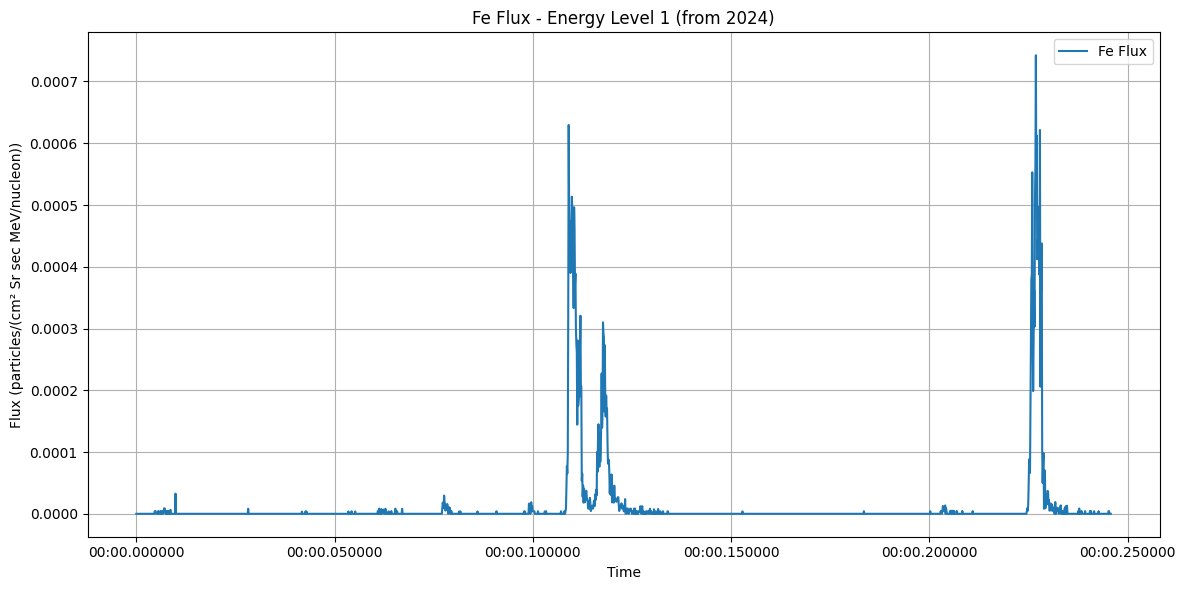

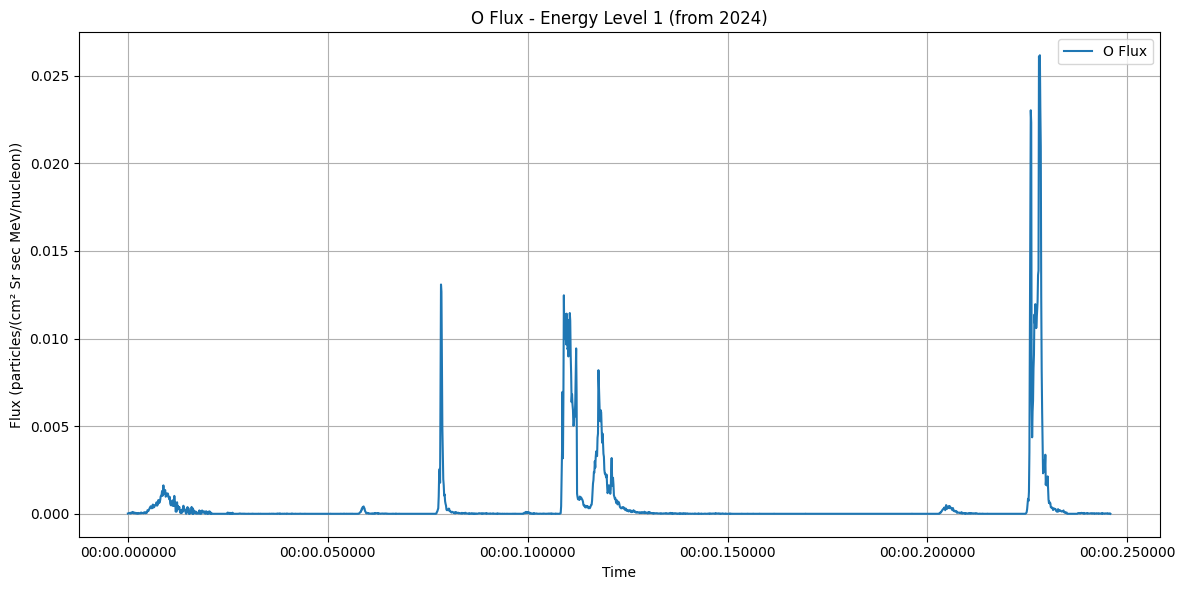

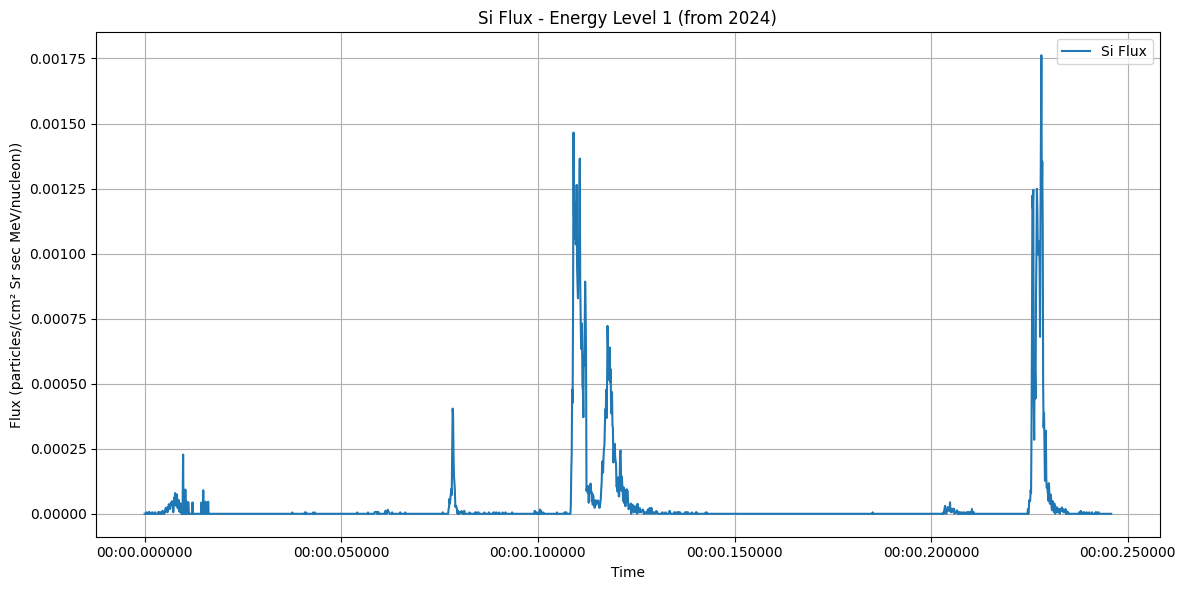

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ... (Your code from cell 1 and cell 2)

def plot_element_fluxes(data_3d, datetime_values, element_mapping, energy_level, start_year):
    """
    Plots separate graphs for flux data of each element at a specified energy level, 
    starting from a given year and omitting bad data.

    Args:
        data_3d (numpy.ndarray): The 3D data cube (energy, time, element).
        datetime_values (numpy.ndarray): Array of datetime objects for the time axis.
        element_mapping (dict): Dictionary mapping element names to array indices.
        energy_level (int): The energy level to plot.
        start_year (int): The year from which to start plotting data.
    """

    start_time = pd.to_datetime(f'{start_year}-01-01')
    time_mask = datetime_values >= start_time

    for element_name, element_index in element_mapping.items():
        plt.figure(figsize=(12, 6))  # Create a separate figure for each element

        element_flux = data_3d[energy_level - 1, time_mask, element_index]

        # Omit bad data points
        valid_data_mask = element_flux != -999.9
        element_flux = element_flux[valid_data_mask]
        element_time = datetime_values[time_mask][valid_data_mask]

        plt.plot(element_time, element_flux, label=f'{element_name} Flux')

        plt.xlabel('Time (Day of Year)')
        plt.ylabel('Flux (particles/(cm² Sr sec MeV/nucleon))')  # Added units
        plt.title(f'{element_name} Flux - Energy Level {energy_level} (from {start_year})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Cell 3: Plot data for energy level 1 from 2023 onwards
plot_element_fluxes(all_flux_data, datetime_values, element_mapping, energy_level=1, start_year=2024)